# Homework #2 (Due 09/25/2019, 11:59pm)
## Sampling and Monte Carlo Integration

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators:**

## Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [0]:
### Import basic libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn as sk
import scipy.stats as st

from sklearn.linear_model import LinearRegression
from collections import namedtuple

### Plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set(style="darkgrid", palette="colorblind", color_codes=True)
fig_wide = (11, 4)

## Problem Description

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of the random variable $X$:

$$
h(x) = 7 * \mathrm{exp}\left\{\frac{(x-4)^2}{-2}\right\} + 3 * \mathrm{exp}\left\{\frac{(x-8)^2}{-2 * 0.7^2}\right\}
$$

Our goal is to compute the expected value of $h(X)$:
$$
I = \mathbb{E}_{X\sim f_X}\left[h(X)\right] = \int_{\Omega} h(x) f_X(x)dx,
$$
where $\Omega$ is the domain of $f_X$.


## Part I. Implement Some Monte Carlo Estimates

Approximate $\mathbb{E}_{X\sim f_X}[h(X)]$ using the Monte Carlo integration methods and your choice of a reasonable fixed $S$ (for rejection sampling, this means run the algorithm $S$ times):


1. ***Inverse CDF Sampling*** and naive Monte Carlo estimation.<br><br>

2. ***Rejection Sampling*** and naive Monte Carlo estimation, using each of the following

  - a uniform proposal distribution
  - a normal proposal distribution 

  and your choice of reasonable parameters for the proposal distributions.<br><br>
  
3. ***Importance Sampling*** using each of the following

  - a uniform importance distribution 
  - a normal importance distribution

  and your choice of reasonable parameters for the importance distributions.<br><br>
  
2. ***Stratified Sampling*** using 4 strata, whose end points are given by
$$
[1, 3, 5, 7, 9].
$$
Use inverse cdf sampling on each stratum.

### 1.1 Inverse CDF Sampling

We can estimate $I$ with the naive Monte Carlo scheme

\begin{align}
    \hat I = \frac{1}{S}\sum_{s=1}^S h(X_s),\ X_s \sim F^{-1}(a)\quad,
\end{align}

where $X_s$ is sampled from $f_X(x)$ by evaluating its inverse CDF 
$F^{-1}(a) = \int_0^a f_X(x)\text d x$ 
at $S$ samples drawn from the uniform distribution $a \sim Unif[0, 1]$. 
We also don't need to worry about a normalizing constant in this case because 
$\int_\Omega f_X(x) \text d x = 1$ already. 

Finding the CDF first, we have

\begin{align}
    F(a) = 
    \begin{cases}
    \frac{1}{12}\left.\left( \frac{x^2}{2} - x \right)\right|_1^a
    ,& 1 \le x \le 3 \\
    -\frac{1}{12}\left.\left( \frac{x^2}{2} - 5x \right)\right|_3^a 
    + \frac{1}{6}
    ,& 3 < x \le 5 \\
    \frac{1}{6}\left.\left( \frac{x^2}{2} - 5x \right)\right|_5^a + \frac{1}{3}
    ,& 5 < x \le 7 \\
    -\frac{1}{6}\left.\left( \frac{x^2}{2} - 9x \right)\right|_7^a + \frac{2}{3}
    ,& 7 < x \le 9
    \end{cases}\quad.
\end{align}

Note: The second term in each case is found by summing the previous case at its upper limit of $a$ to get the cummulative total. 

Evaluating this, we have

\begin{align}
    F(a) = 
    \begin{cases}
        \frac{a^2 - 2a}{24} + \frac{1}{24}
        ,& 0 \le a \le \frac{1}{6} \\
        \frac{10a - a^2}{24} - \frac{17}{24}
        ,& \frac{1}{6} < a \le \frac{1}{3} \\
        \frac{a^2 - 10a}{12} + \frac{29}{12}
        ,& \frac{1}{3} < a \le \frac{2}{3} \\
        \frac{18a - a^2}{12} - \frac{23}{4}
        ,& \frac{2}{3} < a \le 1
    \end{cases} \quad.
\end{align}

Inverting the first case (where $y \equiv F^{-1}(a)$ for convenience), we get

\begin{align}
    a = \frac{y^2 - 2y}{24} + \frac{1}{24}
    \quad\Longrightarrow\quad
    0 &= y^2 - 2y + 1 - 24a \\
    \quad\Longrightarrow\quad
    y &= \frac{2 \pm \sqrt{4 - 4(1 - 24a)}}{2} \\
    &= 1 \pm \sqrt{1 - (1-24a)} \\
    &= 1 \pm 2\sqrt{6a} \quad.
\end{align}

The CDF is a monotonically increasing function so we choose the appropiate branch to mirror this ($1 + 2\sqrt{6a}$ in this case). Similar reasoning holds for the other intervals of the domain. The lower bound on $a$ is what the previous sum was (in this case 0), and the upper bound if found by plugging the corresponding upper bound of $x$ into its CDF. Repeating this process for the other cases, we have the final inverse CDF

\begin{align}
    F^{-1}(a) = 
    \begin{cases}
        1 + 2\sqrt{6a}
        ,& 0 \le a \le \frac{1}{6} \\
        5 - 2\sqrt{2 - 6a}
        ,& \frac{1}{6} < a \le \frac{1}{3} \\
        5 + 2\sqrt{3a - 1}
        ,& \frac{1}{3} < a \le \frac{2}{3} \\
        9 - 2\sqrt{3 - 3a}
        ,& \frac{2}{3} < a \le 1
    \end{cases} \quad.
\end{align}

which is plotted below as a sanity check to make sure it is a strictly increasing function with the proper end points.


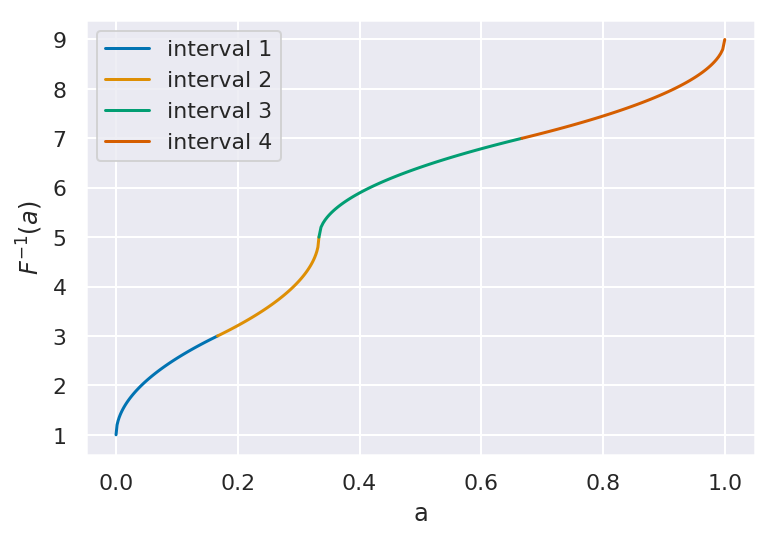

In [2]:
func = namedtuple("func", "name function d u")
F_invs = (
    func(1, lambda a: 1 + 2*np.sqrt(6*a), 0., 1./6.),
    func(2, lambda a: 5 - 2*np.sqrt(2. - 6.*a), 1./6., 1./3.),
    func(3, lambda a: 5 + 2*np.sqrt(3.*a - 1.), 1./3., 2./3.),
    func(4, lambda a: 9 - 2*np.sqrt(3. - 3.*a), 2./3., 1.),
)

for F_inv in F_invs:
    a = np.linspace(F_inv.d, F_inv.u, 100, endpoint=True)
    plt.plot(a, F_inv.function(a), label=f"interval {F_inv.name}")

plt.xlabel('a')
plt.ylabel("$F^{-1}(a)$")

plt.legend()

When we sample from $a\sim Unif[0, 1]$, this will tell us which case in the piecewise inverse CDF to plug into.

Let's build our inverse CDF sampler and naive Monte Carlo estimator below.

In [3]:
# returns appropriate inverse CDF to sample from
def inv_CDF(a):
    cases = [
             [(0. <= a) & (a <= 1./6.), lambda a: 1. + 2.*np.sqrt(6.*a)],
             [(1./6. < a) & (a <= 1./3.), lambda a: 5. - 2.*np.sqrt(2. - 6.*a)],
             [(1./3. < a) & (a <= 2./3.), lambda a: 5. + 2.*np.sqrt(3.*a - 1.)],
             [(2./3. < a) & (a <= 1.), lambda a: 9. - 2.*np.sqrt(3. - 3.*a)],
             [(a < 0) | (a > 1), 0]
    ]
    F_inv = np.piecewise(a, [i[0] for i in cases], [i[1] for i in cases])
    return F_inv

# returns S samples from `inv_CDF`
def inv_CDF_sampler(inv_CDF, S):
    U = np.random.uniform(0, 1, size=S)
    samples = inv_CDF(U)
    return samples

# define h(x)
h = lambda x: 7.*np.exp(-(x - 4.)**2/2.) + 3.*np.exp(-(x - 8.)**2/(2.*0.7**2))

# define inverse sampler for estimator
def sampler_inv(S): 
    return inv_CDF_sampler(inv_CDF, S)

# perform naive monte carlo
def naive_MC(sampler, h, S, N):
    I_estimates, f_estimates = [], []
    for n in range(N):
        samples = sampler(S)
        f_estimates.append(samples)
        I_estimates.append(h(samples).mean()) # sums over S and divides by S
    return  I_estimates, f_estimates

# run monte carlo simulation and print results
S = 1_000
N = 1
I_inv, f_inv = naive_MC(sampler_inv, h, S, N)
mean_inv = np.mean(I_inv)

print("Expectation value estimate for h(X) using inverse CDF sampling")
print("--------------------------------------------------------------")
print(f"mean of {N} trial with {S} samples each: {mean_inv}")

Expectation value estimate for h(X) using inverse CDF sampling
--------------------------------------------------------------
mean of 1 trial with 1000 samples each: 2.4884443985355698


### 1.2 Rejection Sampling

In this scheme, instead of approximating the pdf by sampling from its inverse CDF, we are going to propose a function $M q(x)$ that is simpler than $f_X(x)$, where $q(x)$ defines the shape of our proposed distribution and $M$ scales it such that it envelopes $f_X(x)$. We can then approximate the pdf by computing

\begin{align}
    \frac{f_X(X_s)}{M q(X_s)}\quad.
\end{align}

The approximation is completed by sampling $X_s$ from $q(X)$ and rejecting samples that fail 

\begin{align}
    U \le \frac{f_X(X_s)}{M g(X_s)} \quad,
\end{align}

where $U \sim Unif[0, 1]$. Incorporating this sampler into our naive Monte Carlo scheme, we now have

\begin{align}
    \hat I = \sum_{s=1}^S h(X_s),\ X_s 
    \sim \left[ U \le \frac{f_X(X_s)}{M g(X_s)} \right]
    \quad.
\end{align}

Implementing this below, we get the following estimates for $h$ below, using a uniform and Normal proposal, respectively.
Note: The parameters to best envelope the pdf were chosen graphically (see 2.1).

In [4]:
# computes f_X. handy for plotting later and picking scaling for k
def f_X(x):
    cases = [
             [(1. <= x) & (x <= 3.), lambda x: (x - 1.)/12.],
             [(3. < x) & (x <= 5.), lambda x: -(x - 5.)/12.],
             [(5. < x) & (x <= 7.), lambda x: (x - 5.)/6.],
             [(7. < x) & (x <= 9.), lambda x: -(x - 9.)/6.],
             [(x < 1) | (x > 9), 0]
    ]
    f = np.piecewise(x, [i[0] for i in cases], [i[1] for i in cases])
    return f

# define rejection sampler for estimator
def sampler_rej_unif(S):
    xmin, xmax = 0, 10
    x = np.linspace(xmin, xmax, S)
    k = np.max(f_X(x)) # scales proposal function so that it envelopes f_X
    U = np.random.uniform(0, 1, S)
    g = np.ones_like(x) 
    X_s = np.random.uniform(xmin, xmax, S) # sample from prop
    accept = U <= f_X(X_s) / (k*g) # rejection criteria
    samples = X_s[accept]
    return samples

def sampler_rej_norm(S):
    xmin, xmax = 0, 10
    x = np.linspace(xmin, xmax, S)
    k = 1.4*np.max(f_X(x)) # scales proposal function so that it envelopes f_X
    U = np.random.uniform(0, 1, S)
    mean, var = 5.5, 3.8
    g = lambda x, mean=mean, var=var: np.exp(-(x - mean)**2 / (2*var))
    X_s = np.random.normal(mean, np.sqrt(var), S) # sample from prop
    accept = U <= f_X(X_s) / (k*g(X_s)) # rejection criteria
    samples = X_s[accept]
    return samples

# run monte carlo simulation and print results
I_rej_unif, f_rej_unif = naive_MC(sampler_rej_unif, h, S, N)
I_rej_norm, f_rej_norm = naive_MC(sampler_rej_norm, h, S, N)

mean_rej_unif, var_rej_unif = np.mean(I_rej_unif), np.std(I_rej_unif)**2
mean_rej_norm, var_rej_norm = np.mean(I_rej_norm), np.std(I_rej_norm)**2

print("Expectation value estimate for h(X) using rejection sampling (Uniform proposal):")
print("--------------------------------------------------------------------------------")
print(f"mean of {N} trial with {S} samples each: {mean_rej_unif}")
print()
print("Expectation value estimate for h(X) using rejection sampling (Normal proposal):")
print("---------------------------------------------------------------------------------")
print(f"mean of {N} trial with {S} samples each: {mean_rej_norm}")

Expectation value estimate for h(X) using rejection sampling (Uniform proposal):
--------------------------------------------------------------------------------
mean of 1 trial with 1000 samples each: 2.3477228933653906

Expectation value estimate for h(X) using rejection sampling (Normal proposal):
---------------------------------------------------------------------------------
mean of 1 trial with 1000 samples each: 2.3887042208745863


### 1.3 Importance Sampling

This scheme is similar to rejection sampling in that we propose a simpler distribution $q(x)$ that is similar to the pdf. Instead of rejecting samples though, we keep them all and assign each a weight based on how likely they are to come from $p$ vs. $q$. This is accomplished in the Importance Sampling Monte Carlo Scheme

\begin{align}
    \hat I = \sum_{s=1}^S \frac{f_X(X_s)}{q(X_s)} h(X_s),\ X_s \sim q(X)\quad,
\end{align}

implemented below for a Uniform and Normal proposal pdf, respectively.

In [5]:
# proposal distribution (uniform) sampler. optionally returns likelihood
def sampler_unif(S=None, x=None):
    if S is not None:
        samples = np.random.uniform(low=1, high=9, size=S)
        return samples
    elif x is not None:
        likelihood = st.uniform.pdf(x, loc=1, scale=8)
        return likelihood
    else: 
        return None

# proposal distribution (uniform) sampler. optionally returns likelihood 
def sampler_norm(S=None, x=None):
    if S is not None:
        samples = np.random.normal(loc=5.5, scale=2, size=S)
        return samples
    elif x is not None:
        likelihood = st.norm.pdf(x, loc=5.5, scale=2)
        return likelihood
    else: 
        return None

# importance sampling monte carlo implemention
def IS_MC(sampler, f, h, S, N):
    I_estimates, weights_over_trials = [], []
    for n in range(N):
        samples = sampler(S=S)
        weights = f(samples) / sampler(x=samples)
        weights_over_trials.append(weights)
        I_estimate = weights * h(samples)
        I_estimates.append(I_estimate.mean())
    return I_estimates, weights_over_trials

# run monte carlo simulation and print results
I_IS_unif, weights_IS_unif  = IS_MC(sampler_unif, f_X, h, S, N)
I_IS_norm, weights_IS_norm  = IS_MC(sampler_norm, f_X, h, S, N)

mean_IS_unif, var_IS_unif = np.mean(I_IS_unif), np.std(I_IS_unif)**2
mean_IS_norm, var_IS_norm = np.mean(I_IS_norm), np.std(I_IS_norm)**2

print("Expectation value estimate for h(X) using Importance Sampling (Uniform proposal):")
print("--------------------------------------------------------------------------------")
print(f"mean of {N} trial with {S} samples each: {mean_IS_unif}")
print()
print("Expectation value estimate for h(X) using Importance (Normal proposal):")
print("---------------------------------------------------------------------------------")
print(f"mean of {N} trial with {S} samples each: {mean_IS_norm}")

Expectation value estimate for h(X) using Importance Sampling (Uniform proposal):
--------------------------------------------------------------------------------
mean of 1 trial with 1000 samples each: 2.396868060070902

Expectation value estimate for h(X) using Importance (Normal proposal):
---------------------------------------------------------------------------------
mean of 1 trial with 1000 samples each: 2.5516114325781016


### 1.4 Stratified Sampling

In this final sampling scheme, we perform inverse CDF sampling again, but on sub-domains of $f_X(x)$. Using the four intervals outlined in the problem statement, we can estimate $I$ with

\begin{align}
    \hat I = \sum_{m=1}^M w_m \hat I_m = 
    \sum_{m=1}^M \frac{1}{S_m}
    \sum_{S_m=1}^{S_m} w_m h(X_{S_m}),\ 
    X_{S_m} \sim F_{SS}^{-1}(a) \quad,
\end{align}

where $\hat I_m$ is the estimate on strata $m$, $S_m = w_m S$, and $w_m$ is the weight on interval $m$ that ensures that $f_X(x)$ integrates to $1$ 
$\left( \int_{\Omega_m} f_X(x)\text d x = w_m \right)$. This is important because it converts each segement of $f_X(x)$ into its own normalized pdf that we can then invert $\left( F_{SS}^{-1}(a) \right)$ and sample from $S_m$ times before combining all strata together.

Integrating $f_X(x)$ over each of the four strata, we have $w_n = [1/6, 1/6, 1/3, 1/3]$ for strata $[S_1, S_2, S_3, S_4]$, respectively. Performing similar steps as in 1.1, the normalized, stratified pdf for $f_X(x)$, $f_{SS}(x)$, corresponding CDF, and inverse CDF are then

\begin{align}
    f_X(x) = 
    \begin{cases}
    \frac{1}{2}(x-1), &1\leq x\leq 3\\
    -\frac{1}{2}(x-5), &3< x\leq 5\\
    \frac{1}{2}(x-5), &5< x\leq 7\\
    -\frac{1}{2}(x-9), &7< x\leq 9
    \end{cases},\quad
    F_{SS}(a) = 
    \begin{cases}
        \frac{1}{4} (a - 1)^2 , & 1 \le a \le 3 \\
        -\frac{1}{4} (a-3)(a-7), & 3 < a \le 5 \\
        \frac{1}{4} (a-5)^2, & 5 < a \le 7 \\
        -\frac{1}{4} (a-7)(a-11), & 7 < a \le 9
    \end{cases}, \quad
    F_{SS}^{-1}(a) = 
    \begin{cases}
        1 + 2\sqrt a, & 0 \le a \le 1 \\
        5 - 2\sqrt{1 - a}, & 0 \le a \le 1 \\
        5 + 2\sqrt a, & 0 \le a \le 1 \\
        9 - 2\sqrt{1 - a}, & 0 \le a \le 1
    \end{cases}
\end{align}

Note: The branches in the quadratic solutions for $F_{SS}^{-1}(a)$ were again chosen to match the monotonic trend of $F_{SS}(x)$ on the corresponding interval. This plotted below as a sanity check.

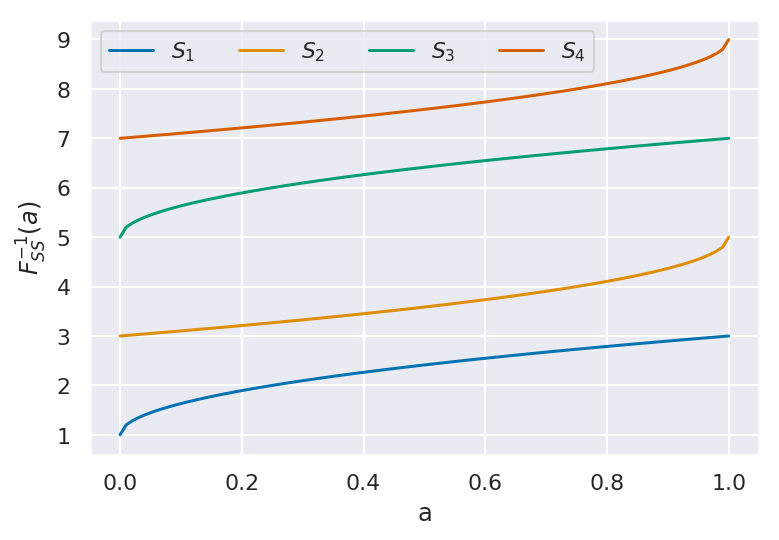

In [6]:
func = namedtuple("func", "name function")
F_SS_invs = (
    func("S_1", lambda a: 1 + 2*np.sqrt(a)),
    func("S_2", lambda a: 5 - 2*np.sqrt(1. - a)),
    func("S_3", lambda a: 5 + 2*np.sqrt(a)),
    func("S_4", lambda a: 9 - 2*np.sqrt(1. - a)),
)

a = np.linspace(0, 1, 100, endpoint=True)
for F_SS_inv in F_SS_invs:
    plt.plot(a, F_SS_inv.function(a), label=f"${F_SS_inv.name}$")

plt.xlabel('a')
plt.ylabel("$F_{SS}^{-1}(a)$")

plt.legend(ncol=4, loc=2)



Implementing the monte carlo integration for this scheme, we have

In [7]:
# returns appropriate inverse CDF to sample from
def inv_CDF_SS(a, m):
    F_SS_inv = F_SS_invs[m].function(a)
    return F_SS_inv

# returns S samples from `inv_CDF_SS`
def inv_CDF_SS_sampler(inv_CDF_SS, m, Sm):
    U = np.random.uniform(0, 1, size=Sm)
    samples = inv_CDF_SS(U, m)
    return samples

# define inverse sampler for estimator
def sampler_SS(m, Sm): 
    return inv_CDF_SS_sampler(inv_CDF_SS, m, Sm)

# perform stratified sampling monte carlo
def SS_MC(sampler, h, weights, M, S, N):
    # `I_estimates` holds N estimates for E[h(X)]
    # `f_estimates` holds N arrays, where each array holds 4
    # arrays of length Sm, one for each M=4
    I_estimates, f_estimates = [], []
    for n in range(N):
        I_m_estimates, f_m_estimates = [], []
        for m in range(M): # loop over strata
            w_m = weights[m]
            Sm = int(w_m*S) # number of samples to take in strata M
            X_Sm = sampler(m, Sm) 
            I_m = np.mean(w_m * h(X_Sm))
            I_m_estimates.append(I_m)
            f_m_estimates.append(X_Sm)
            
        f_estimates.append(f_m_estimates)
        I_estimates.append(np.sum(I_m_estimates))
    return I_estimates, f_estimates

# run monte carlo simulation and print results
M = 4
weights = [1./6., 1./6., 1./3., 1./3.]
I_SS, f_SS = SS_MC(sampler_SS, h, weights, M, S, N)
mean_SS = np.mean(I_SS)

print("Expectation value estimate for h(X) using stratified sampling")
print("--------------------------------------------------------------")
print(f"mean using {M} strata and {N} trial with {S} samples total: {mean_SS}")

Expectation value estimate for h(X) using stratified sampling
--------------------------------------------------------------
mean using 4 strata and 1 trial with 1000 samples total: 2.4769942993392746


## Part II. Debug Your Samplers

1. Visualize the pdf $f_X$ as well as samples obtained from Inverse CDF Sampling and Rejection Sampling (for both proposal distributions). It's probably better to make separate plots for each set of samples.

  What does the comparison say about the quality of your samples? In particular, which sampler (and which proposal distribution) produces "better" samples? Is this surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?
  
  **Hint:** you might find it helpful to visualize the proposal distributions along with $f_X$ in your analysis of rejection sampling.<br><br>

2. Visualize the distribution of the importance weights (one for each importance distribution). 
  
   Is the weight distribution surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?

   What do these importance weights tell you about the quality of your importance sampling estimate? 
   
     **Hint:** you might find it helpful to visualize the importnce distributions along with $f_X$ and $h$ in your analysis of importance sampling.<br><br>
     
3. Visualize the distribution of all the samples across strata. Is the distribution what you expect -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?<br><br>

4. (**Extra Credit**) Compute the ***effective sample size (ESS)*** of the importance sampling estimates (for both distributions). You'll need to look up the definition of ESS (there are three commonly used definitions, pick any one). How does the effective sample size relate to the trends in the importance weight distributions?

### 2.1 Visualize Inverse CDF and Rejection Sampling 

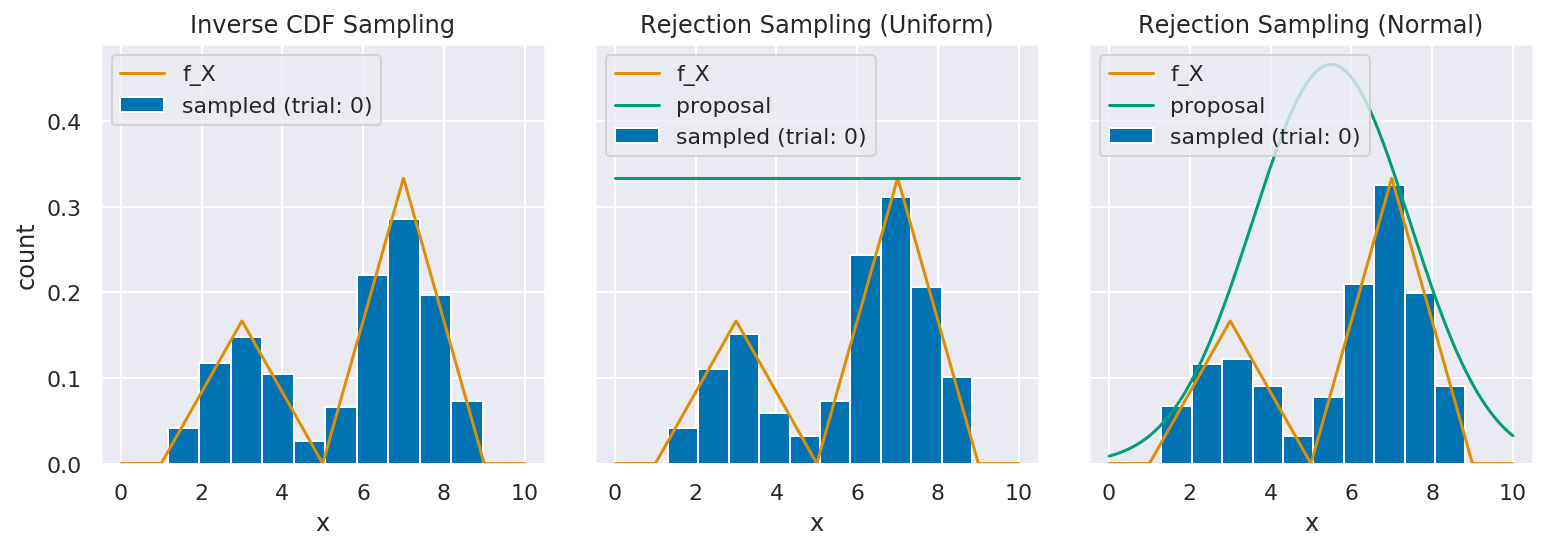

In [8]:
fig, axes = plt.subplots(1, 3, figsize=fig_wide, sharex=True, sharey=True)

n = 0 # trial to show
sampled_label = f"sampled (trial: {n})"

# inverse CDF sampling
xmin, xmax = 0, 10
x = np.linspace(xmin, xmax, S)
axes[0].hist(f_inv[n], density=True, label=sampled_label)
axes[0].plot(x, f_X(x), label="f_X")
axes[0].legend(loc=2)
axes[0].set_title("Inverse CDF Sampling")

# rejection sampling: uniform proposal dist.
M = np.max(f_X(x))
axes[1].hist(f_rej_unif[n], density=True, label=sampled_label)
axes[1].plot(x, f_X(x), label="f_X")
axes[1].plot(x, M*np.ones_like(x), label="proposal")
axes[1].legend(loc=2)
axes[1].set_title("Rejection Sampling (Uniform)")

# rejection sampling: normal proposal dist.
M *= 1.4
norm = lambda x, mean=5.5, var=3.8: np.exp(-(x - mean)**2 / (2*var))
axes[2].hist(f_rej_norm[n], density=True, label=sampled_label)
axes[2].plot(x, f_X(x), label="f_X")
axes[2].plot(x, M*norm(x), label="proposal")
axes[2].legend(loc=2)
axes[2].set_title("Rejection Sampling (Normal)")

axes[0].set_ylabel("count")
for ax in axes: ax.set_xlabel('x')
fig.tight_layout()

The Inverse CDF tends to produce better samples.

### 2.2 Visualize Importance Sampling

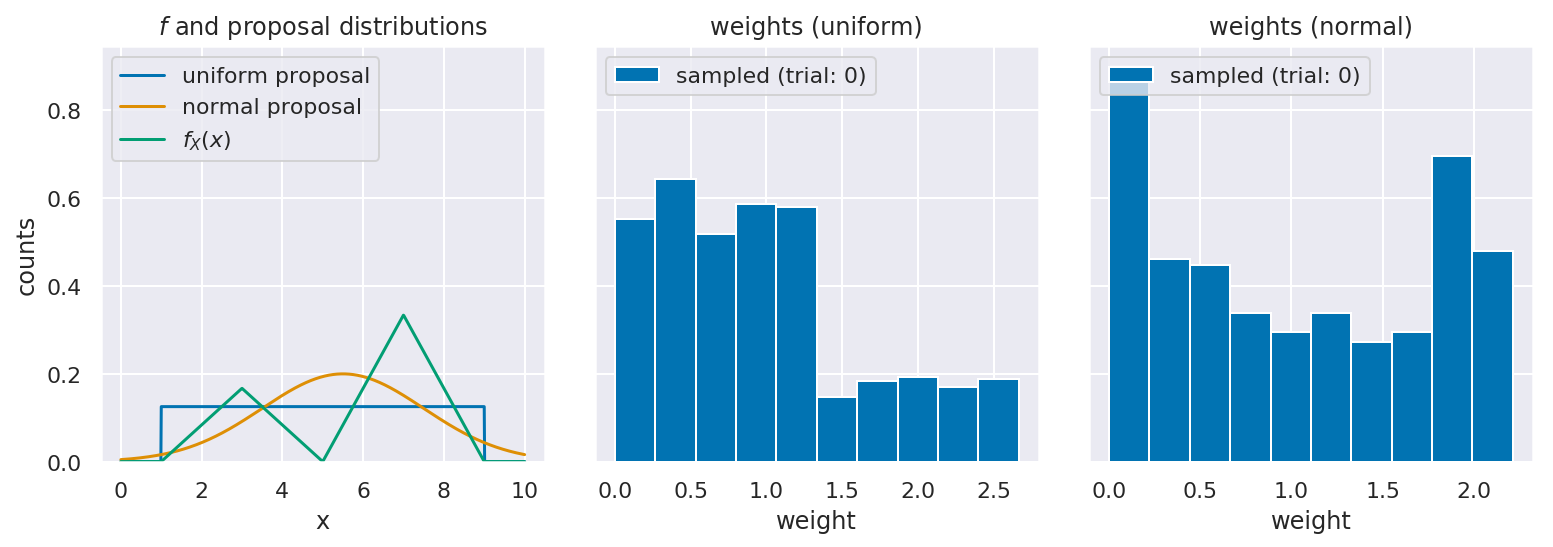

In [9]:
fig, axes = plt.subplots(1, 3, figsize=fig_wide, sharey=True)

n = 0 # which trial to show
weights_label = f"weights (trial: {n})"

# f and proposal dists.
xmin, xmax = 0, 10
x = np.linspace(xmin, xmax, S)
q_unif = st.uniform.pdf(x, loc=1, scale=8) # Unif[1, 9]
q_norm = st.norm.pdf(x, loc=5.5, scale=2)
axes[0].plot(x, q_unif, label="uniform proposal")
axes[0].plot(x, q_norm, label="normal proposal")
axes[0].plot(x, f_X(x), label=r"$f_X(x)$")
axes[0].set_xlabel("x")
axes[0].set_title("$f$ and proposal distributions")

axes[1].hist(weights_IS_unif[n], density=True, label=sampled_label)
axes[1].set_title("weights (uniform)")

axes[2].hist(weights_IS_norm[n], density=True, label=sampled_label)
axes[2].set_title("weights (normal)")

for ax in [axes[1], axes[2]]: ax.set_xlabel("weight")
for ax in axes: ax.legend(loc=2)
axes[0].set_ylabel("counts")

fig.tight_layout()

The weights for each proposal distribtion tend to be around 1 or larger and not 0, which is encouraging about the sample size.

### 2.3 Visualize Stratified Sampling

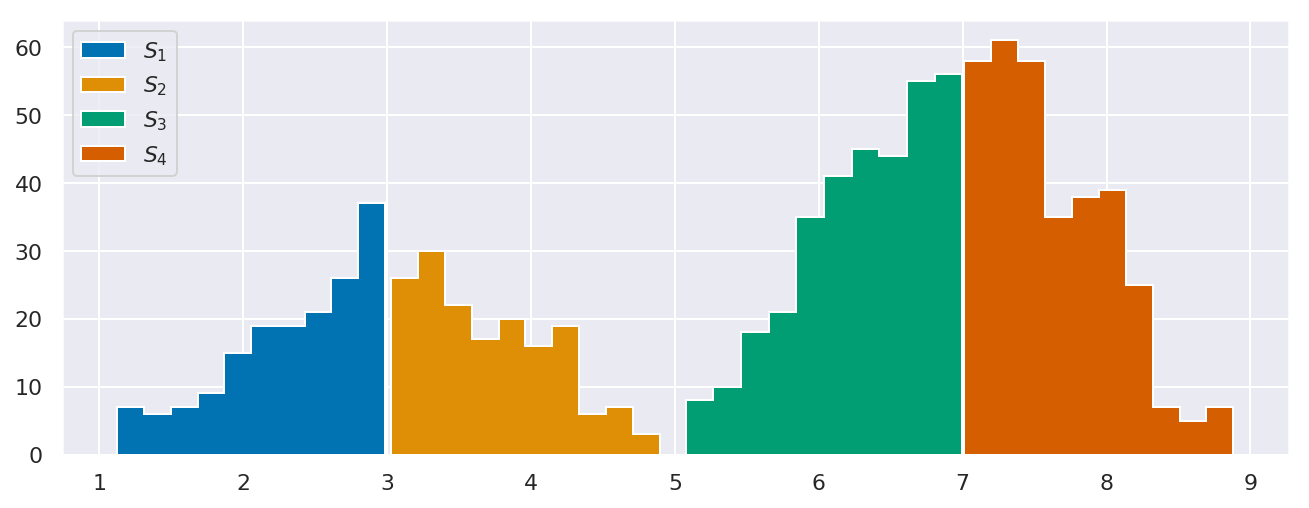

In [17]:
fig, ax = plt.subplots(figsize=fig_wide)
for i, sample in enumerate(f_SS[0], start=1):
    ax.hist(sample, density=False, histtype="stepfilled", label=f"$S_{i}$")
ax.legend()

It looks like $f_X(x)$ ! The scale is off though.

### 2.4 Effective Sample Size

The effective sample size (ESS) helps us quantify how well how proposal dsitribution matches $f_X(x)$. Say for example $\text{ESS} = 40$, then that means our estimate is about as a good as taking 40 samples directly from 
$f_X(x)$. The closer ESS is to our total number of samples, the better. 
For unnormalized weights $w$, the formula is

\begin{align}
    \text{ESS} = \frac{\left( \sum_{n=1}^N w_n \right)^2}{\sum_{n=1}^N w_n^2}
    \quad .
\end{align}

The ESS for each proposal distribution for each sample is shown below.

In [11]:
n = 0 # trial number

ESS_unif_frac = (np.sum(weights_IS_unif[n])**2 / np.sum(weights_IS_unif[n]**2))/S
ESS_norm_frac = (np.sum(weights_IS_norm[n])**2 / np.sum(weights_IS_norm[n]**2))/S

print(f"ESS / {S} Samples")
print("------------------")
print(f"uniform: {ESS_unif_frac}")
print(f"normal: {ESS_norm_frac}")

ESS / 1000 Samples
------------------
uniform: 0.6712172263853569
normal: 0.6620996378936402


From this analysis we can see that the effective sample size is larger for the uniform proposal distribution than the normal version. This might help explain why the variance on the estimate for $\hat I$ is lower for the uniform distribution case.

## Part III: Variance Reduction

1. Compute the sample variance of the four Monte Carlo estimates in Part I. Based on the discussions in lecture, which sampling methods (and proposal/importance distributions) is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?<br><br>

3. Based on your experiments, would you feel comfortable concluding which type of Monte Carlo estimate will **generally** have the lowest variance? Why or why not?<br><br>

4. (**Extra Credit**) Implement the control variate Monte Carlo estimate for $I$ for your choice of a control variate $g$ and sample using the inverse CDF sampler. Argue for why your choice of $g$ is appropriate and demonstrate that your control variate estimate has lower variance than the naive Monte Carlo using inverse CDF sampling.

### 3.1 Variance Summary

Running our simulations $N$ times with $S$ total samples each gives the following statistics for the estimates

In [12]:
N = 1_000
M = 4

I_inv, _ = naive_MC(sampler_inv, h, S, N)
I_rej_unif, _ = naive_MC(sampler_rej_unif, h, S, N)
I_rej_norm, _ = naive_MC(sampler_rej_norm, h, S, N)
I_IS_unif, _  = IS_MC(sampler_unif, f_X, h, S, N)
I_IS_norm, _  = IS_MC(sampler_norm, f_X, h, S, N)
I_SS, _ = SS_MC(sampler_SS, h, weights, M, S, N)

summary = namedtuple("summary", "name dist")
sampling_methods = (
    summary("Inverse CDF    ", I_inv), 
    summary("Rejection (Uniform)", I_rej_unif),
    summary("Rejection (Normal)", I_rej_norm),
    summary("Importance (Uniform)", I_IS_unif),
    summary("Importance (Normal)", I_IS_norm),
    summary("Stratified     ", I_SS)
)

print(f"Sample Variance (N={N}, S={S})")
print("------------------------------")
for method in sampling_methods: 
    print(f"{method.name}:\t{np.std(method.dist)**2}")

Sample Variance (N=1000, S=1000)
------------------------------
Inverse CDF    :	0.0034285205489820417
Rejection (Uniform):	0.011992370684929575
Rejection (Normal):	0.00792516820568393
Importance (Uniform):	0.0034500065485521805
Importance (Normal):	0.005015628521656007
Stratified     :	0.0006020955155626727


The corresponding histograms and standard deviation values are displayed below.

Inverse CDF    : 2.44014281480229 +/- 0.05855356990809392$
Rejection (Uniform): 2.44378511013897 +/- 0.1095096830646933$
Rejection (Normal): 2.433213920657 +/- 0.08902341380605402$
Importance (Uniform): 2.4380666402316926 +/- 0.058736756367305305$
Importance (Normal): 2.437497412805059 +/- 0.07082110223412233$
Stratified     : 2.439067854786703 +/- 0.02453763467742302$


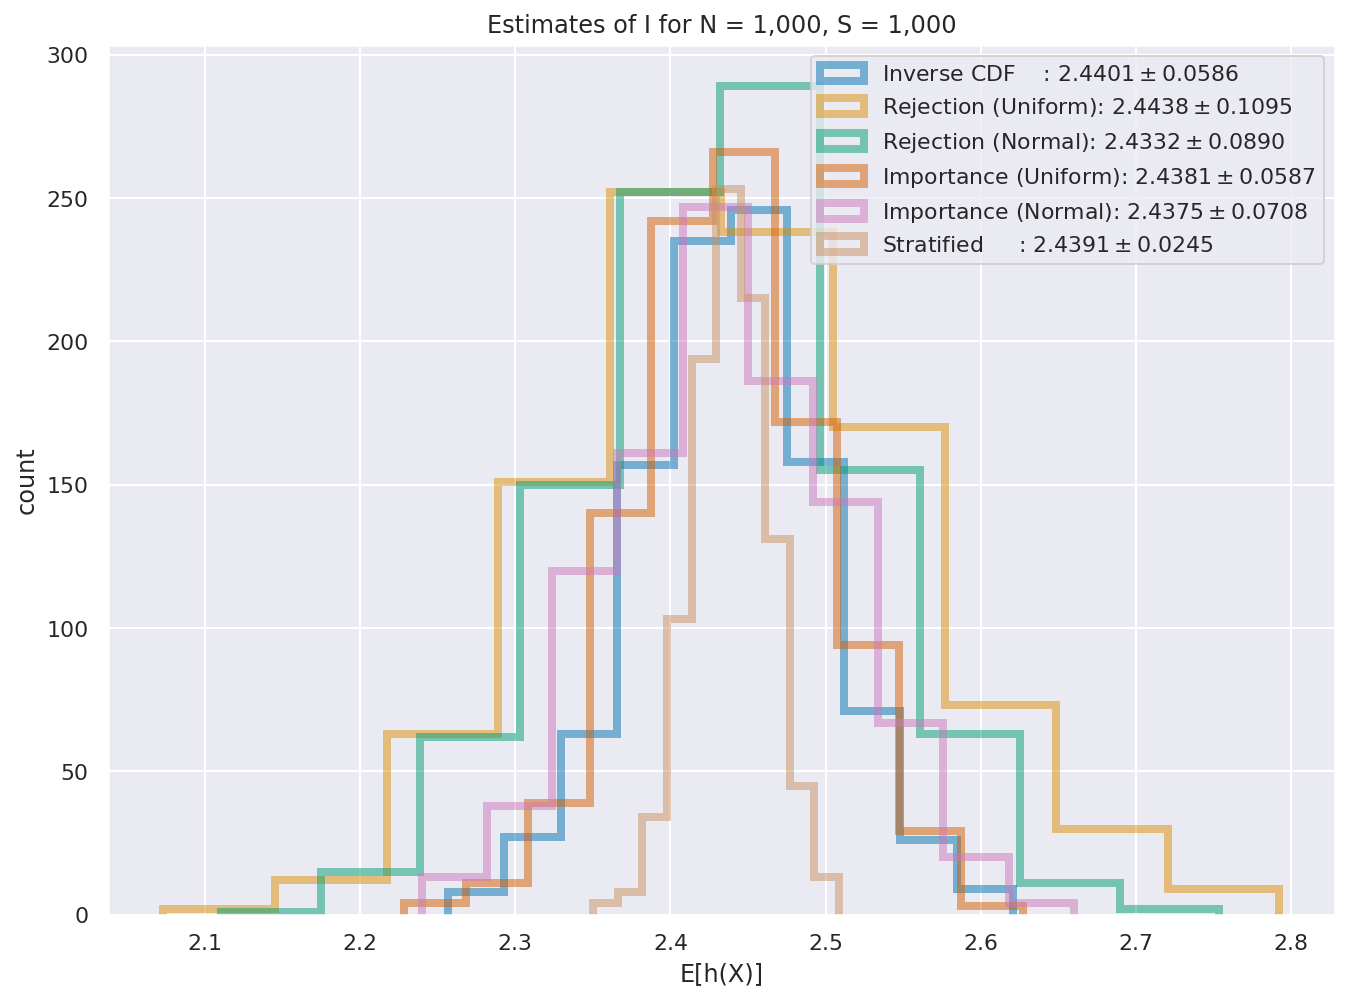

In [13]:
fig, ax = plt.subplots(figsize=(11, 8))

for method in sampling_methods:
    name, mean, std = method.name, np.mean(method.dist), np.std(method.dist)
    label = f"{name}: ${mean:.4f} \pm {std:.4f}$"
    ax.hist(method.dist, bins=10, lw=4, alpha=0.5, label=label, histtype="step")

    print(f"{name}: {mean} +/- {std}$")
ax.legend()

ax.set_xlabel("E[h(X)]")
ax.set_ylabel("count")

ax.set_title(f"Estimates of I for N = {N:,}, S = {S:,}")

plt.show()

We see the nice result that stratified sampling returns the lowest variance on our sample estimates! This is due to the variance going like one over the number of samples. The schemes involving using the normal as a proposal distribution tend to do worse than their uniform distribution counterparts, but this is very dependent on the parameters used for the norm's pdf. This may be because the uniform distribution did a better job of approximating $f_X(x)$.

### 3.2 Variance Discussion

In general, I would not be comfortable using this expriments as evidence that stratified sampling returns the smallest variances in general. The sampling is sensitive to the distributions we choose to try an approximate $f_X(x)$. More tests/diagnostics are needed.